This script will plot multiple spectra with VNA data obtained using **SaveDataAs** menu.

# Import libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import math
import copy
import csv

import function as func

# Setting

In [20]:
outdir = './output/20240508-SMAcablecheck_compare_VNA_multiple_spectrum/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
    pass

# set colorful lines
cmap = plt.get_cmap('jet')
plt.rcParams['font.size'] = 18

In [3]:
datadir = '../../data/20240508_NIFS_SMAcable'
filenames = [ 
    '160cm#1_F-Fconnector_30cm.csv',
    '160cm#1_F-Fconnector_30cm_afterBroken.csv',
    '160cm#2_F-Fconnector_30cm.csv',
    '160cmx2_flangex2_30cmx2_F-Fx2_M-M.csv',
    '30cm_F-Fconnector_M-Mconnector.csv',
    '30cm_F-Fconnector_M-Mconnector_2.csv',
    '30cm_flange#1_M-Mconnector.csv',
    '30cm_flange#2_M-Mconnector.csv',
    '30cmx2_F-Fx2_M-M.csv',
    'M-Mconnector.csv',
    'M-Mconnector_2.csv',
]
labels = [
    '160cm cable #1',
    '160cm cable #1 after connector broken',
    '160cm cable #2',
    '160cm cable x2 + Hermetic connector x2',
    '30cm cable + F-F + M-M',
    '30cm cable + F-F + M-M 2nd',
    'Hermetic connector #1',
    'Hermetic connector #2',
    '30cm cable x2 + F-F x2 + M-M',
    'M-M',
    'M-M 2nd',
]
subtract_files = [
    ['30cm_F-Fconnector_M-Mconnector.csv'],
    ['30cm_F-Fconnector_M-Mconnector.csv'],
    ['30cm_F-Fconnector_M-Mconnector.csv'],
    ['30cmx2_F-Fx2_M-M.csv'],
    ['M-Mconnector.csv'],
    ['M-Mconnector.csv'],
    ['30cm_F-Fconnector_M-Mconnector.csv'],
    ['30cm_F-Fconnector_M-Mconnector.csv'],
    ['M-Mconnector.csv'],
    ['M-Mconnector_2.csv'],
    [],
]
freq_min = 4 # [GHz]
freq_max = 34 # [GHz]
ratio_min = 0.
ratio_max = 1.2
dB_min = -20 # [dB]
dB_max = 2 # [dB]
legendON = True
csvType = 'VNA'; # freq, dBm
#channel = None
channel = 0

# default average binning
nFreqAve = 100

In [4]:
func.print_list(filenames)
func.print_list(labels)
func.print_list(subtract_files)

filenames (size=11) = ['160cm#1_F-Fconnector_30cm.csv', '160cm#1_F-Fconnector_30cm_afterBroken.csv', '160cm#2_F-Fconnector_30cm.csv', '160cmx2_flangex2_30cmx2_F-Fx2_M-M.csv', '30cm_F-Fconnector_M-Mconnector.csv', '30cm_F-Fconnector_M-Mconnector_2.csv', '30cm_flange#1_M-Mconnector.csv', '30cm_flange#2_M-Mconnector.csv', '30cmx2_F-Fx2_M-M.csv', 'M-Mconnector.csv', 'M-Mconnector_2.csv']
labels (size=11) = ['160cm cable #1', '160cm cable #1 after connector broken', '160cm cable #2', '160cm cable x2 + Hermetic connector x2', '30cm cable + F-F + M-M', '30cm cable + F-F + M-M 2nd', 'Hermetic connector #1', 'Hermetic connector #2', '30cm cable x2 + F-F x2 + M-M', 'M-M', 'M-M 2nd']
subtract_files (size=11) = [['30cm_F-Fconnector_M-Mconnector.csv'], ['30cm_F-Fconnector_M-Mconnector.csv'], ['30cm_F-Fconnector_M-Mconnector.csv'], ['30cmx2_F-Fx2_M-M.csv'], ['M-Mconnector.csv'], ['M-Mconnector.csv'], ['30cm_F-Fconnector_M-Mconnector.csv'], ['30cm_F-Fconnector_M-Mconnector.csv'], ['M-Mconnector.csv']

# Read csv data

In [5]:
freqs_array = []
powers_array = []
for filename in filenames:
    _freq, _power = func.read_csv(f'{datadir}/{filename}', csvType, channel=channel)
    
    # Select data between freq_min and freq_max
    _power = _power[_freq<=freq_max]
    _freq = _freq[_freq<=freq_max]
    _power = _power[_freq>=freq_min]
    _freq = _freq[_freq>=freq_min]
    
    freqs_array.append(_freq)
    powers_array.append(_power)
    pass

freqs_array = np.array(freqs_array)
powers_array = np.array(powers_array)

In [6]:
print(freqs_array)
print(powers_array)
print(freqs_array)
print(powers_array)

[[ 4.         4.0009375  4.001875  ... 33.998125  33.9990625 34.       ]
 [ 4.         4.0009375  4.001875  ... 33.998125  33.9990625 34.       ]
 [ 4.         4.0009375  4.001875  ... 33.998125  33.9990625 34.       ]
 ...
 [ 4.         4.0009375  4.001875  ... 33.998125  33.9990625 34.       ]
 [ 4.         4.0009375  4.001875  ... 33.998125  33.9990625 34.       ]
 [ 4.         4.0009375  4.001875  ... 33.998125  33.9990625 34.       ]]
[[0.53141791 0.53221801 0.53166788 ... 0.08534011 0.08517636 0.08534901]
 [0.53113818 0.53137992 0.53081183 ... 0.08418131 0.08464016 0.08482063]
 [0.53439772 0.533332   0.53352831 ... 0.08151111 0.08148394 0.08118455]
 ...
 [0.65813467 0.65599142 0.65536776 ... 0.18131625 0.1806727  0.18039236]
 [0.74526732 0.74320034 0.74290974 ... 0.30731771 0.30831564 0.30773995]
 [0.6212858  0.62032251 0.62241205 ... 0.30297403 0.3041649  0.30318108]]
[[ 4.         4.0009375  4.001875  ... 33.998125  33.9990625 34.       ]
 [ 4.         4.0009375  4.001875  ... 

###  Plot Power [Ratio]

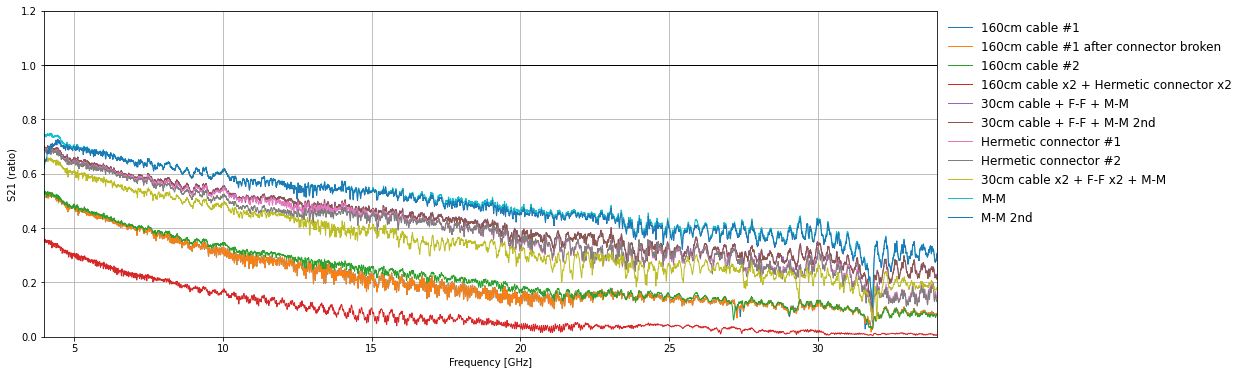

In [7]:
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    plt.plot(freqs_array[i], powers_array[i], label=label, marker='', markersize=0.5, linestyle='-', linewidth=1)
    #plt.plot(freqs_array[i], powers_array[i], label=label, marker='o', markersize=0.5, linestyle='', linewidth=1)
    pass
plt.plot([freq_min, freq_max], [1, 1], ls='-', c='k', lw=1)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 (ratio)') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,6) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
plt.ylim(ratio_min, ratio_max) #y軸範囲指定
plt.grid(True)

if legendON: plt.legend(fontsize=12, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f'{outdir}/compare_VNA_multiple_spectrum_all.png')
plt.show()

# Averaging

In [8]:
## Averaging
freqs_ave_array = []
powers_ave_array = []
powers_ave_err_array = []
for i, filename in enumerate(filenames):
    _freq_ave, tmp = func.average_list(freqs_array[i], naverage=nFreqAve)
    _power_ave, _power_ave_err = func.average_list(powers_array[i], naverage=nFreqAve)
    freqs_ave_array.append(_freq_ave)
    powers_ave_array.append(_power_ave)
    powers_ave_err_array.append(_power_ave_err)
    pass
freqs_ave_array = np.array( freqs_ave_array )
powers_ave_array = np.array( powers_ave_array )
powers_ave_err_array = np.array( powers_ave_err_array )

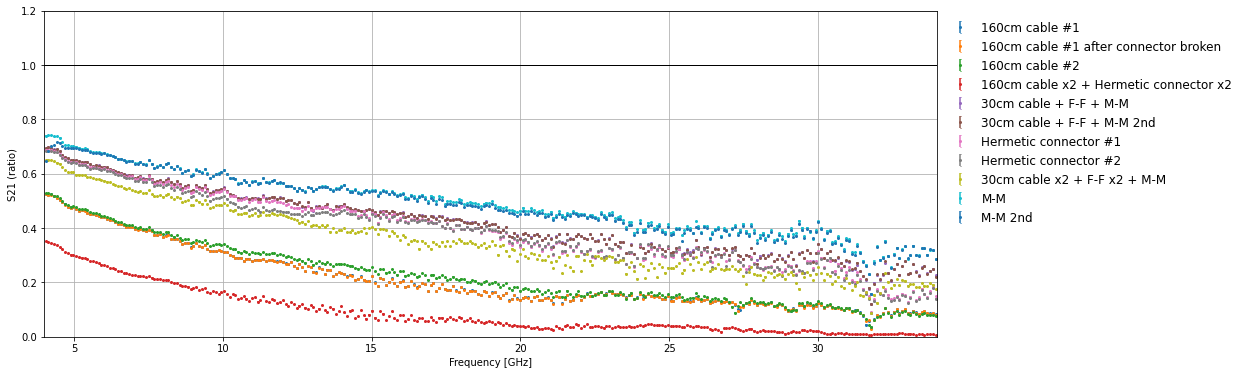

In [9]:
## Plotting
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    plt.errorbar(freqs_ave_array[i], powers_ave_array[i], yerr=powers_ave_err_array[i], 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass
plt.plot([freq_min, freq_max], [1, 1], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 (ratio)') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5, 6) #x軸範囲指定
plt.ylim(ratio_min, ratio_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=12, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/compare_VNA_spectrum_all_average.png")
plt.show()

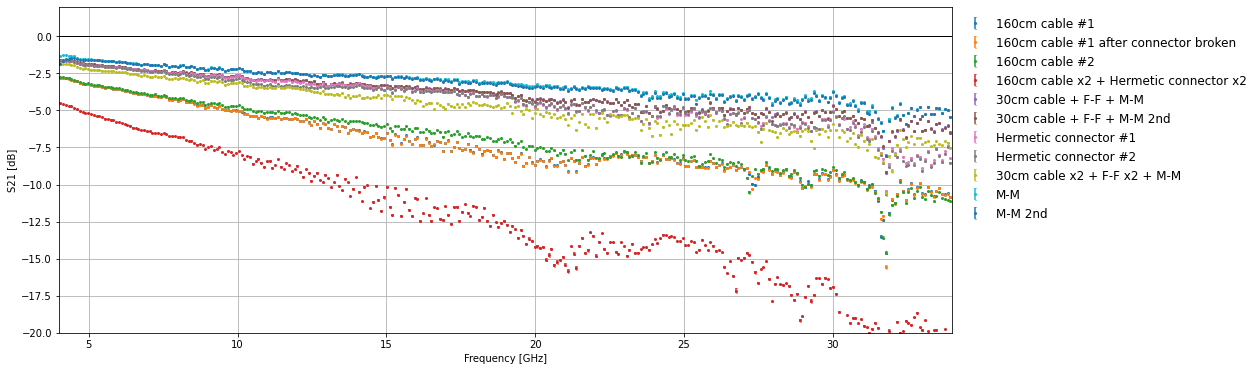

In [10]:
## Plotting in dB
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    _dB, _dBerr = func.ratio_to_dB(powers_ave_array[i], powers_ave_err_array[i])
    plt.errorbar(freqs_ave_array[i], _dB, yerr=_dBerr, 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass
plt.plot([freq_min, freq_max], [0, 0], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5, 6) #x軸範囲指定
plt.ylim(dB_min, dB_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=12, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/compare_VNA_spectrum_all_average_dB.png")
plt.show()

# Subtract cable loss

In [11]:
# power, powerlist, power_err, power_errlist should be "ratio" (not [dB])!!
def subtract_loss(power, powerlist, filelist, subtract_filelist, power_err=None, power_errlist=None):
    print('-- subtract loss --')
    print(f'subtract file list = {subtract_filelist}')
    new_power = copy.deepcopy(power)
    if power_err is not None:
        new_power_err = copy.deepcopy(power_err)
    else:
        new_power_err = None
        pass
    
    for j, (_power, _file) in enumerate(zip(powerlist, filelist)):
        if _file in subtract_filelist:
            print(f'matched file name = {_file}')
            new_power = new_power / _power
            if (power_err is not None) and (power_errlist is not None):
                _power_err = power_errlist[j]
                new_power_err = np.sqrt( np.power(new_power_err/_power, 2) + np.power(new_power * _power_err/_power, 2) )
                pass
            pass
        pass
    return new_power, new_power_err

## Subtracting
freqs_sub_array = []
powers_sub_array = []
powers_sub_err_array = []
for i, (_freq, _power, _power_err) in enumerate(zip(freqs_ave_array, powers_ave_array, powers_ave_err_array)):
    _freq_sub = _freq
    _power_sub, _power_sub_err = subtract_loss(_power, powers_ave_array, filenames, subtract_files[i], power_err=_power_err, power_errlist=powers_ave_err_array)
    freqs_sub_array.append(_freq_sub)
    powers_sub_array.append(_power_sub)
    powers_sub_err_array.append(_power_sub_err)
    pass
freqs_sub_array = np.array( freqs_sub_array )
powers_sub_array = np.array( powers_sub_array )
powers_sub_err_array = np.array( powers_sub_err_array )

-- subtract loss --
subtract file list = ['30cm_F-Fconnector_M-Mconnector.csv']
matched file name = 30cm_F-Fconnector_M-Mconnector.csv
-- subtract loss --
subtract file list = ['30cm_F-Fconnector_M-Mconnector.csv']
matched file name = 30cm_F-Fconnector_M-Mconnector.csv
-- subtract loss --
subtract file list = ['30cm_F-Fconnector_M-Mconnector.csv']
matched file name = 30cm_F-Fconnector_M-Mconnector.csv
-- subtract loss --
subtract file list = ['30cmx2_F-Fx2_M-M.csv']
matched file name = 30cmx2_F-Fx2_M-M.csv
-- subtract loss --
subtract file list = ['M-Mconnector.csv']
matched file name = M-Mconnector.csv
-- subtract loss --
subtract file list = ['M-Mconnector.csv']
matched file name = M-Mconnector.csv
-- subtract loss --
subtract file list = ['30cm_F-Fconnector_M-Mconnector.csv']
matched file name = 30cm_F-Fconnector_M-Mconnector.csv
-- subtract loss --
subtract file list = ['30cm_F-Fconnector_M-Mconnector.csv']
matched file name = 30cm_F-Fconnector_M-Mconnector.csv
-- subtract loss --


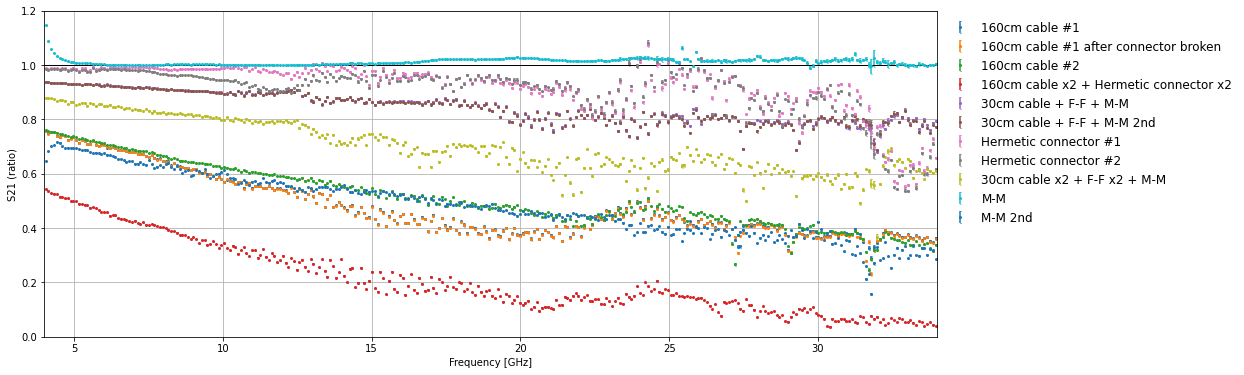

In [12]:
## Plotting
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    plt.errorbar(freqs_sub_array[i], powers_sub_array[i], yerr=powers_sub_err_array[i], 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass
plt.plot([freq_min, freq_max], [1, 1], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 (ratio)') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.ylim(ratio_min, ratio_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=12, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/compare_VNA_spectrum_all_subtract.png")
plt.show()

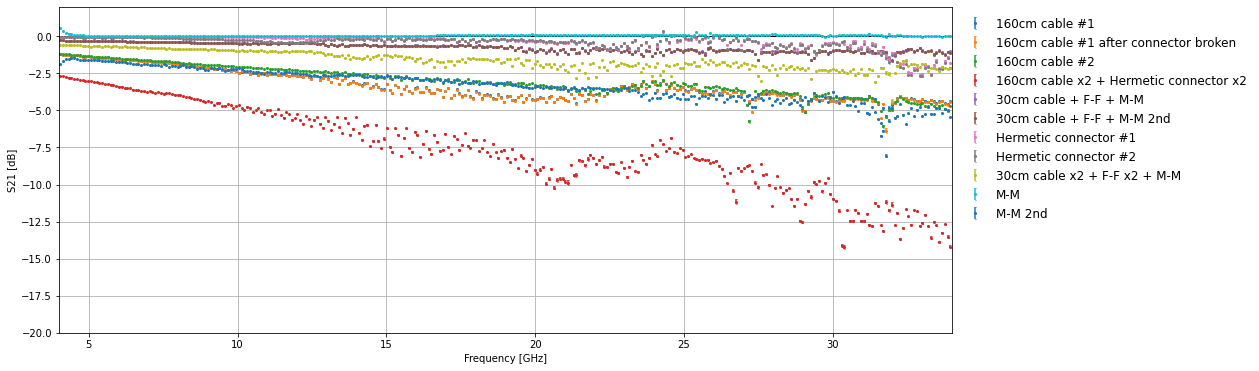

In [13]:
## Plotting in [dB]
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    _dB, _dBerr = func.ratio_to_dB(powers_sub_array[i], powers_sub_err_array[i])
    plt.errorbar(freqs_sub_array[i], _dB, yerr=_dBerr, 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass
plt.plot([freq_min, freq_max], [0, 0], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-50, 5) #y軸範囲指定
plt.ylim(dB_min, dB_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=12, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/compare_VNA_spectrum_all_subtract_dB.png")
plt.show()

# Comparison

## 160 cm cables

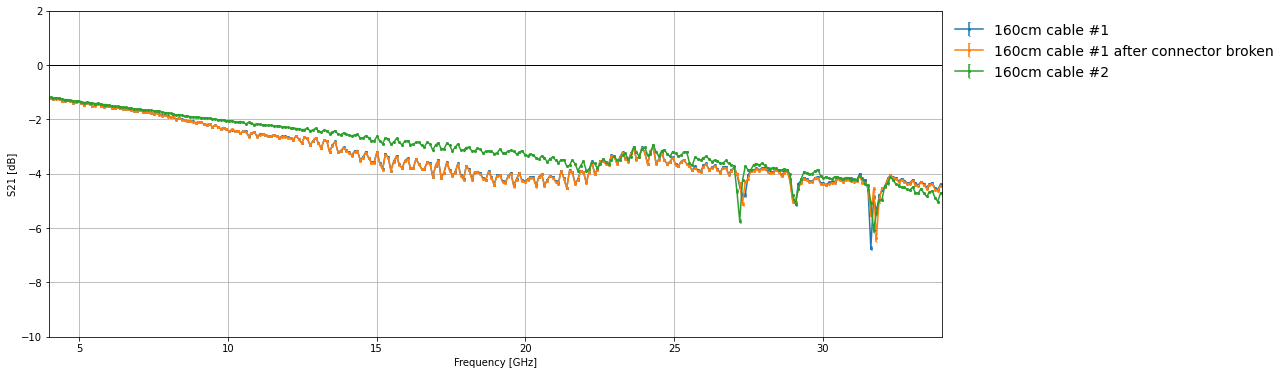

In [14]:
select_index = [0, 1, 2]
## Plotting in [dB]
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    if i not in select_index: continue
    _dB, _dBerr = func.ratio_to_dB(powers_sub_array[i], powers_sub_err_array[i])
    plt.errorbar(freqs_sub_array[i], _dB, yerr=_dBerr, 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                 ls='-'
                )
    pass
plt.plot([freq_min, freq_max], [0, 0], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-50, 5) #y軸範囲指定
plt.ylim(-10, dB_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=14, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/160cm_cables.png")
plt.show()

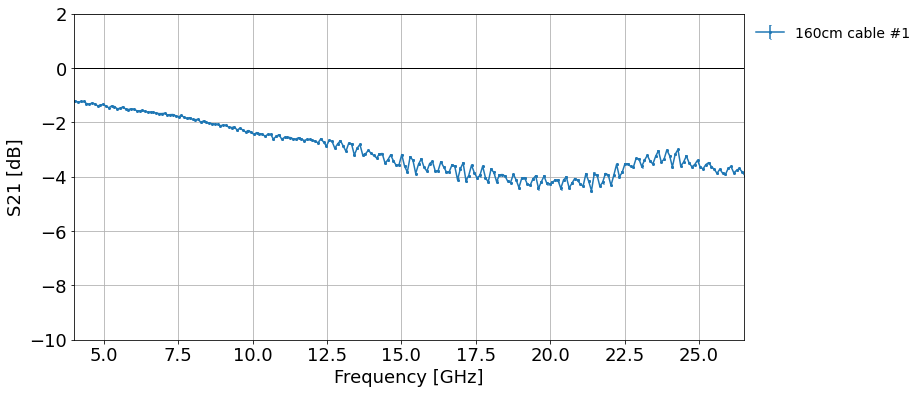

In [25]:
select_index = [0]
## Plotting in [dB]
fig = plt.figure(figsize=(12,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    if i not in select_index: continue
    _dB, _dBerr = func.ratio_to_dB(powers_sub_array[i], powers_sub_err_array[i])
    plt.errorbar(freqs_sub_array[i], _dB, yerr=_dBerr, 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                 ls='-'
                )
    pass
plt.plot([freq_min, freq_max], [0, 0], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 [dB]') #y軸の名前
plt.xlim(freq_min,26.5) #x軸範囲指定
#plt.ylim(-50, 5) #y軸範囲指定
plt.ylim(-10, dB_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=14, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

#plt.savefig(f"{outdir}/160cm_cables.png")
plt.show()

## Hermetic connectors

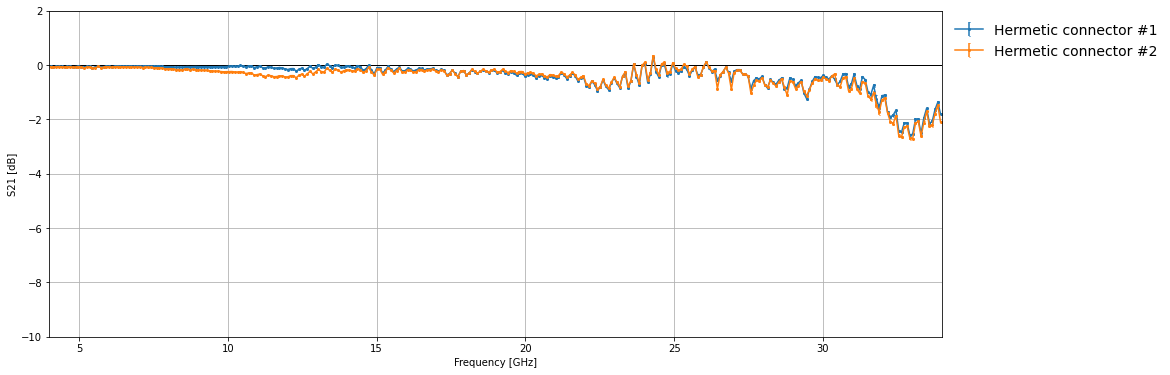

In [16]:
select_index = [6, 7]
## Plotting in [dB]
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    if i not in select_index: continue
    _dB, _dBerr = func.ratio_to_dB(powers_sub_array[i], powers_sub_err_array[i])
    plt.errorbar(freqs_sub_array[i], _dB, yerr=_dBerr, 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                 ls='-'
                )
    pass
plt.plot([freq_min, freq_max], [0, 0], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-50, 5) #y軸範囲指定
plt.ylim(-10, dB_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=14, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/hermetic_connectors.png")
plt.show()

## 160 cm cables x2 + Hermetic connectors x2

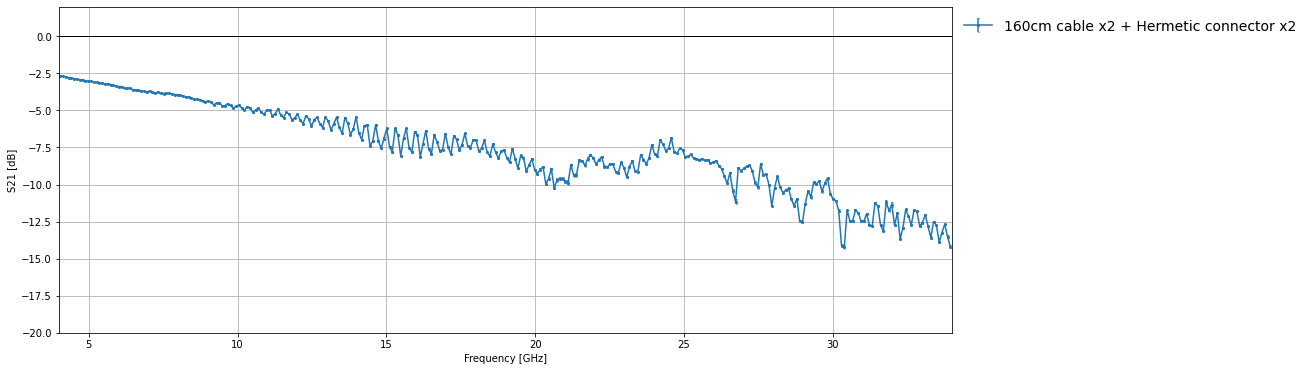

In [17]:
select_index = [3]
## Plotting in [dB]
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    if i not in select_index: continue
    _dB, _dBerr = func.ratio_to_dB(powers_sub_array[i], powers_sub_err_array[i])
    plt.errorbar(freqs_sub_array[i], _dB, yerr=_dBerr, 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                 ls='-'
                )
    pass
plt.plot([freq_min, freq_max], [0, 0], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-50, 5) #y軸範囲指定
plt.ylim(dB_min, dB_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=14, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/160cm-cablesx2_hermetic-connectorsx2.png")
plt.show()

## 30 cm cables, F-F adapter, M-M adapter

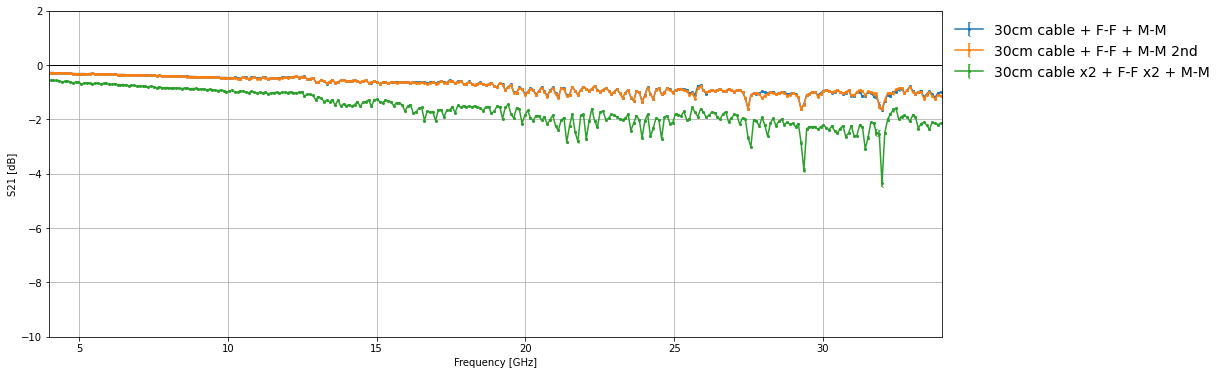

In [18]:
select_index = [4, 5, 8]
## Plotting in [dB]
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    if i not in select_index: continue
    _dB, _dBerr = func.ratio_to_dB(powers_sub_array[i], powers_sub_err_array[i])
    plt.errorbar(freqs_sub_array[i], _dB, yerr=_dBerr, 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                 ls='-'
                )
    pass
plt.plot([freq_min, freq_max], [0, 0], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-50, 5) #y軸範囲指定
plt.ylim(-10, dB_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=14, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/160cm-cablesx2_hermetic-connectorsx2.png")
plt.show()

## M-M adapter + VNA cables (No subtraction)

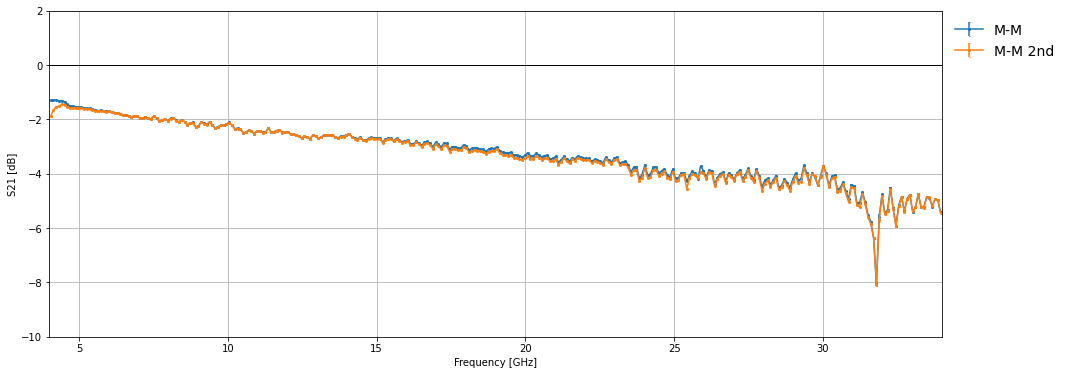

In [19]:
select_index = [9, 10]
## Plotting in [dB]
fig = plt.figure(figsize=(16,6))
for i, (filename, label) in enumerate(zip(filenames, labels)):
    if i not in select_index: continue
    _dB, _dBerr = func.ratio_to_dB(powers_ave_array[i], powers_ave_err_array[i])
    plt.errorbar(freqs_sub_array[i], _dB, yerr=_dBerr, 
                 label=label, capsize=0.5, fmt='o', markersize=2, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                 ls='-'
                )
    pass
plt.plot([freq_min, freq_max], [0, 0], ls='-', c='k', lw=1)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('S21 [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-50, 5) #y軸範囲指定
plt.ylim(-10, dB_max) #y軸範囲指定
plt.grid(True)
if legendON: plt.legend(fontsize=14, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f"{outdir}/160cm-cablesx2_hermetic-connectorsx2.png")
plt.show()